In [1]:
import pandas as pd
import numpy as np
import gseapy as gp
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rcParams
import re
import os

os.chdir("/data/wuqinhua/scPhase/COVID")

In [2]:
import pandas as pd
def _df_append(self, other, ignore_index=False, verify_integrity=False, sort=False):
    return pd.concat([self, other], ignore_index=ignore_index, sort=sort, axis=0)

pd.DataFrame.append = _df_append

In [3]:
gene_df_H = pd.read_csv("./ensemble_gene_attributions_H.csv")
top_genes_H = gene_df_H.sort_values('mean_attribution', ascending=False)['gene'].head(20).tolist()
enr_H=gp.enrichr(gene_list=top_genes_H,gene_sets=['GO_Biological_Process_2025','KEGG_2021_Human','Reactome_Pathways_2024',"COVID-19_Related_Gene_Sets_2021"],organism='Human',outdir='/home/wuqinhua/Project/PHASE_1r/AttnMoE_test/result/COVID/Analysis/Figure/GSEA_plot',cutoff=1)

gene_df_M = pd.read_csv("./ensemble_gene_attributions_M.csv")
top_genes_M = gene_df_M.sort_values('mean_attribution', ascending=False)['gene'].head(20).tolist()
enr_M=gp.enrichr(gene_list=top_genes_M,gene_sets=['GO_Biological_Process_2025','KEGG_2021_Human','Reactome_Pathways_2024',"COVID-19_Related_Gene_Sets_2021"],organism='Human',outdir='/home/wuqinhua/Project/PHASE_1r/AttnMoE_test/result/COVID/Analysis/Figure/GSEA_plot',cutoff=1)

gene_df_S = pd.read_csv("./ensemble_gene_attributions_S.csv")
top_genes_S = gene_df_S.sort_values('mean_attribution', ascending=False)['gene'].head(20).tolist()
enr_S=gp.enrichr(gene_list=top_genes_S,gene_sets=['GO_Biological_Process_2025','KEGG_2021_Human','Reactome_Pathways_2024',"COVID-19_Related_Gene_Sets_2021"],organism='Human',outdir='/home/wuqinhua/Project/PHASE_1r/AttnMoE_test/result/COVID/Analysis/Figure/GSEA_plot',cutoff=1)


In [4]:
enr_H_results = enr_H.results.copy()
enr_H_results['Group'] = 'Healthy'

enr_M_results = enr_M.results.copy()
enr_M_results['Group'] = 'Moderate'

enr_S_results = enr_S.results.copy()
enr_S_results['Group'] = 'Severe'

In [5]:
combined_results = pd.concat([enr_H_results, enr_M_results, enr_S_results], ignore_index=True)
significant_results = combined_results[combined_results['Adjusted P-value'] < 0.05]

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because

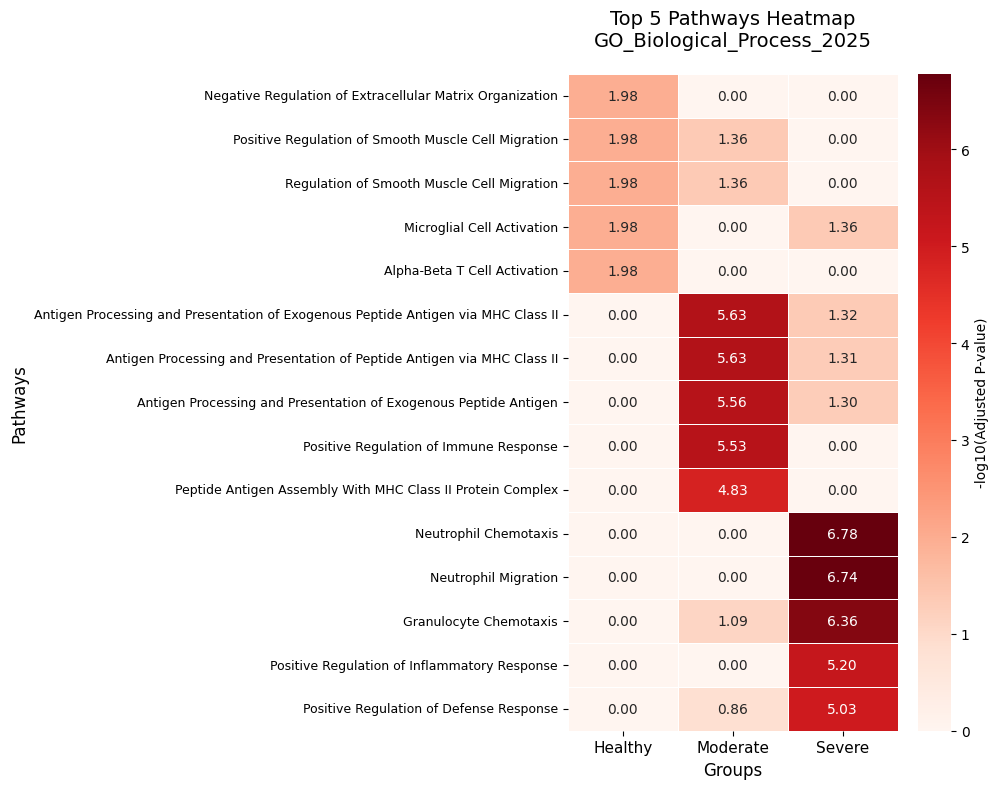

In [6]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


rcParams['font.sans-serif'] = ['Arial']
rcParams['axes.unicode_minus'] = False

def create_top_pathways_heatmap(enr_H, enr_M, enr_S, gene_set_filter='GO_Biological_Process_2025', top_n=10):

    def get_top_pathways(enr_result, gene_set, n=top_n):
        df = enr_result.results.copy()
        df_filtered = df[(df['Gene_set'] == gene_set) & (df['Adjusted P-value'] < 0.05)]
        top_pathways = df_filtered.nsmallest(n, 'Adjusted P-value')
        return top_pathways[['Term', 'Adjusted P-value', 'Odds Ratio']]
    
    h_top = get_top_pathways(enr_H, gene_set_filter, top_n)
    m_top = get_top_pathways(enr_M, gene_set_filter, top_n)
    s_top = get_top_pathways(enr_S, gene_set_filter, top_n)
    

    all_pathways = pd.concat([h_top['Term'], m_top['Term'], s_top['Term']]).unique()

    heatmap_data = pd.DataFrame(index=all_pathways, columns=['Healthy', 'Moderate', 'Severe'])

    for pathway in all_pathways:
        h_match = h_top[h_top['Term'] == pathway]
        if len(h_match) > 0:
            heatmap_data.loc[pathway, 'Healthy'] = -np.log10(h_match['Adjusted P-value'].iloc[0])
        else:
            h_all = enr_H.results[(enr_H.results['Gene_set'] == gene_set_filter) & 
                                 (enr_H.results['Term'] == pathway)]
            if len(h_all) > 0:
                heatmap_data.loc[pathway, 'Healthy'] = -np.log10(h_all['Adjusted P-value'].iloc[0])
            else:
                heatmap_data.loc[pathway, 'Healthy'] = 0

        m_match = m_top[m_top['Term'] == pathway]
        if len(m_match) > 0:
            heatmap_data.loc[pathway, 'Moderate'] = -np.log10(m_match['Adjusted P-value'].iloc[0])
        else:
            m_all = enr_M.results[(enr_M.results['Gene_set'] == gene_set_filter) & 
                                 (enr_M.results['Term'] == pathway)]
            if len(m_all) > 0:
                heatmap_data.loc[pathway, 'Moderate'] = -np.log10(m_all['Adjusted P-value'].iloc[0])
            else:
                heatmap_data.loc[pathway, 'Moderate'] = 0

        s_match = s_top[s_top['Term'] == pathway]
        if len(s_match) > 0:
            heatmap_data.loc[pathway, 'Severe'] = -np.log10(s_match['Adjusted P-value'].iloc[0])
        else:
            s_all = enr_S.results[(enr_S.results['Gene_set'] == gene_set_filter) & 
                                 (enr_S.results['Term'] == pathway)]
            if len(s_all) > 0:
                heatmap_data.loc[pathway, 'Severe'] = -np.log10(s_all['Adjusted P-value'].iloc[0])
            else:
                heatmap_data.loc[pathway, 'Severe'] = 0

    heatmap_data = heatmap_data.astype(float)

    plt.figure(figsize=(10, max(8, len(all_pathways) * 0.15)))

    ax = sns.heatmap(heatmap_data, 
                     annot=True,
                     fmt='.2f',
                     cmap='Reds',
                     cbar_kws={'label': '-log10(Adjusted P-value)'},
                     linewidths=0.5,
                     linecolor='white')
    

    plt.title(f'Top {top_n} Pathways Heatmap\n{gene_set_filter}', fontsize=14, pad=20)
    plt.xlabel('Groups', fontsize=12)
    plt.ylabel('Pathways', fontsize=12)
    
    cleaned_pathway_labels = [re.sub(r'\s*\([^)]*\)$', '', pathway).strip() 
                              for pathway in heatmap_data.index]
    ax.set_yticklabels(cleaned_pathway_labels, rotation=0, fontsize=9)
    
    ax.set_xticklabels(['Healthy', 'Moderate', 'Severe'], rotation=0, fontsize=11)
    
    plt.tight_layout()
    plt.savefig(f"./Analysis/Figure/GSEA_plot/top_{top_n}_pathways_heatmap_{gene_set_filter}_20.pdf", dpi=300, bbox_inches='tight')
    plt.show()
    
    return heatmap_data, all_pathways


heatmap_go, pathways_go = create_top_pathways_heatmap(enr_H, enr_M, enr_S, 
                                                     'GO_Biological_Process_2025', 
                                                     top_n=5)                           
